In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}
#

In [2]:
!python --version
!pip -q install /kaggle/input/d/ryati131457/pytorchtabnet/pytorch_tabnet-2.0.1-py3-none-any.whl

Python 3.7.10


* ### I just tried different parameters and weights of 2  models. Cross validation with different folds was also attempted, but failed.

In [3]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

#我加的===================================================================

def RSI(close,n):
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

#========================================================================

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
#     train = train[:100]
#     test=test[:100]
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'wap3': [np.sum, np.mean, np.std],
        'wap4': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return3': [np.sum, realized_volatility, np.mean, np.std],
        'log_return4': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    #我加的===================================================================
    df_new_features = df[['time_id']].copy()
    df['mid'] = (df['ask_price1']+ df['bid_price1'])/2
    #STD(price)
    for window in [100,200,300,400,500]:
        df[f'mid_ma_{window}'] = df['mid'].rolling(window=window).mean()
        #|price-MA|
        df[f'price_to_ma_{window}'] = abs(df['mid'] - df[f'mid_ma_{window}'])
        df[f'price_to_ma_{window}'].bfill(inplace=True)
        df_new_features[f'price_to_ma_{window}'] = df.groupby('time_id')[f'price_to_ma_{window}'].transform('mean')
    for n in [30,60,100]:
        df[f'rsi_{n}']=RSI(df['mid'],n=n)
        df[f'rsi_{n}'].bfill(inplace=True)
        df_new_features[f'rsi_{n}'] = df.groupby('time_id')[f'rsi_{n}'].transform('mean')
    df_new_features.drop_duplicates(subset='time_id', keep='first', inplace=True)     
    df_feature = df_feature.merge(df_new_features, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    df_feature.drop(['time_id'], axis = 1, inplace = True)
    #我加的===================================================================
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [4]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)


Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 42.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [5]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

In [6]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [7]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

226

In [8]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    print(newDf.shape)
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
(0, 227)
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
(3, 227)
[3, 6, 9, 18, 61, 63, 86, 97]
(0, 227)
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
(0, 227)
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
(0, 227)
[81]
(0, 227)
[8, 80]
(0, 227)


In [9]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  import sys


In [10]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
print(mat1)
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

      time_id  wap1_sum_0c1  wap1_sum_1c1  wap1_sum_2c1  wap1_sum_3c1  \
0           5    454.259460    450.296722    410.733185    350.107635   
1          11    338.439728    320.296692    278.055267    233.907928   
2          16    352.636505    360.082367    347.626770    256.215057   
3          31    312.892395    302.954620    298.578033    231.109253   
4          62    327.286407    314.466064    315.001099    210.724350   
...       ...           ...           ...           ...           ...   
3825    32751    419.968994    395.118561    361.749359    297.389282   
3826    32753    372.915985    347.497681    303.217072    275.159363   
3827    32758    311.283264    327.945435    290.676208    234.331451   
3828    32763    443.204437    451.020905    408.540771    354.972992   
3829    32767    357.900848    373.544617    305.278687    252.666580   

      wap1_sum_4c1  wap1_sum_5c1  wap1_sum_6c1  wap1_mean_0c1  wap1_mean_1c1  \
0       506.105530    537.815308    476.310

In [11]:
import gc
del mat1,mat2
gc.collect()

20

## Tabnet

In [12]:
USE_PRECOMPUTE_FEATURES = True  # Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = True  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization

In [13]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
] # might be problems in these columns


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module): 
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 #folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []
    kfold = KFold(n_splits = 3, random_state = 2021, shuffle = True)
    for cv_idx, (train_idx, valid_idx) in enumerate(kfold.split(train)):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience, 'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs, patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=4, drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             #folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = 100,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    
    for cv_idx, (train_idx, valid_idx) in enumerate(kfold.split(train)):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


## LGBM

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429005	training's RMSPE: 0.198406	valid_1's rmse: 0.000441736	valid_1's RMSPE: 0.205029
[500]	training's rmse: 0.000406641	training's RMSPE: 0.188063	valid_1's rmse: 0.000427725	valid_1's RMSPE: 0.198526
[750]	training's rmse: 0.000392987	training's RMSPE: 0.181748	valid_1's rmse: 0.000420488	valid_1's RMSPE: 0.195167
[1000]	training's rmse: 0.000382851	training's RMSPE: 0.177061	valid_1's rmse: 0.000416324	valid_1's RMSPE: 0.193234
[1250]	training's rmse: 0.000374682	training's RMSPE: 0.173283	valid_1's rmse: 0.000413803	valid_1's RMSPE: 0.192064
Did not meet early stopping. Best iteration is:
[1300]	training's rmse: 0.000373224	training's RMSPE: 0.172609	valid_1's rmse: 0.000413174	valid_1's RMSPE: 0.191772
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000428514	training's RMSPE: 0.198526	valid_1's rmse: 0.000440305	valid_1's

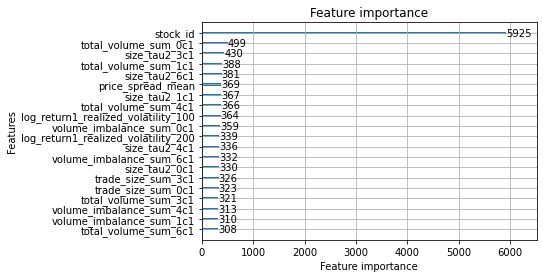

In [16]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1300,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb_1= train_and_evaluate_lgb(train, test,params0)
# predictions_lgb_2= train_and_evaluate_lgb(train, test,params1)
# test['target'] = predictions_lgb_1
# test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [17]:
train.shape[1]
#0.19065

280

In [18]:

from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.195, patience=7, verbose=0,
    mode='min')


In [19]:
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [20]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)


In [21]:
train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [22]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [23]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

In [24]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [25]:
import gc
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')
del mat1,mat2
del train,test
gc.collect()

22

## FFNN

In [26]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(276,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model


In [27]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [28]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.19, patience=7, verbose=0,
    mode='min')

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), features_to_consider]
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    X_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), features_to_consider]
    y_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 4s 10ms/step - loss: 22.7472 - val_loss: 0.8286
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.7889 - val_loss: 0.7669
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.7077 - val_loss: 0.5741
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6528 - val_loss: 0.6530
Epoch 5/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6178 - val_loss: 0.5130
Epoch 6/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.5455 - val_loss: 0.5842
Epoch 7/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.5228 - val_loss: 0.5194
Epoch 8/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.8056 - val_loss: 0.3246
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.2714 - val_loss: 0.2376
Epoch 10/1000
168/168 [==============================] - 1s 5ms/step - lo

In [29]:
test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str) 
#test_nn[target_name] = (test_predictions_nn*0.455+predictions_lgb_1*0.265+preds_tab*0.3)
test_nn[target_name] = test_predictions_nn


score = round(rmspe(y_true = train_nn[target_name].values, y_pred = train_nn[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test_nn[['row_id', target_name]].head(3))
test_nn[['row_id', target_name]].to_csv('submission.csv',index = False)

RMSPE NN: 1.0 - Folds: [0.20864, 0.2114, 0.2106, 0.21479, 0.21252]


,row_id,target
0,0-4,0.004207
1,0-32,0.002332
2,0-34,0.002332


It's a fork from https://www.kaggle.com/alexioslyon/lgbm-baseline and other great kaggles.thanks a lot!

In [30]:
# total time is around 7:30